# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

# Ratings

In [2]:
tester_1 = pd.read_csv(r"C:\Users\desus\OneDrive - Danmarks Tekniske Universitet\Fall_2025\Cognitive_Modelling\Kareninator\data\ratings\s243933_image_ratings.csv")
tester_2 = pd.read_csv(r"C:\Users\desus\OneDrive - Danmarks Tekniske Universitet\Fall_2025\Cognitive_Modelling\Kareninator\data\ratings\s254232_image_ratings.csv")

In [3]:
ratings_tester_1 = tester_1['Rating'].tolist()
ratings_tester_2 = tester_2['Rating'].tolist()
# ratings = ratings_tester_1 + ratings_tester_2
# norm_ratings_1 = [(x - min(ratings_tester_1)) / (max(ratings_tester_1) - min(ratings_tester_1)) for x in ratings_tester_1]

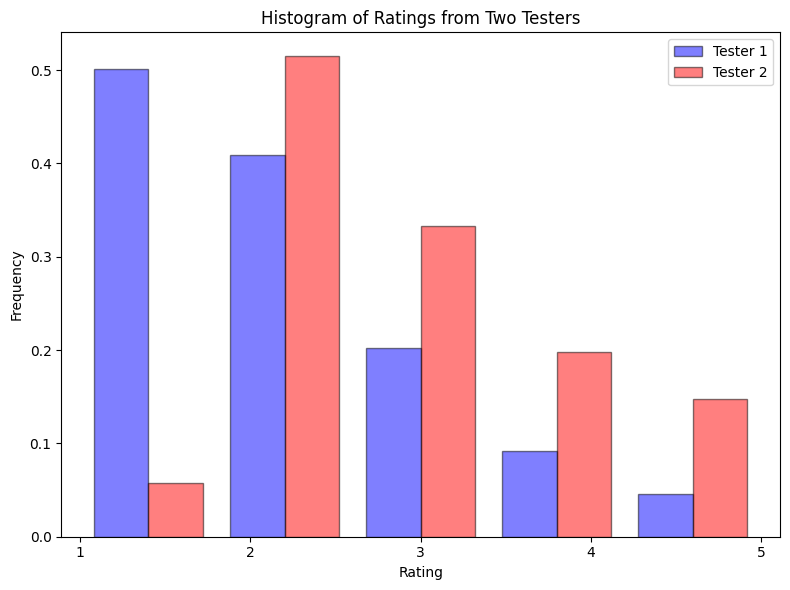

In [25]:
# Plot histogram of ratings from both testers
fig = plt.figure(figsize=(8, 6))
plt.hist([ratings_tester_1, ratings_tester_2], bins=5, density=True, histtype='bar', color=['Blue', 'Red'], label=['Tester 1', 'Tester 2'], edgecolor="black", alpha=0.5)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Histogram of Ratings from Two Testers")
plt.xticks([1, 2, 3, 4, 5])
plt.tight_layout()
plt.legend();

In [5]:
# plt.hist(ratings, [1,2,3,4,5], edgecolor="black")
# plt.xlabel("Value")
# plt.ylabel("Frequency")
# plt.title("Histogram of Values")
# plt.show()

# Data Matrix

In [6]:
# Load images
image_folder = r"C:\Users\desus\OneDrive - Danmarks Tekniske Universitet\Fall_2025\Cognitive_Modelling\Kareninator\data\preprocessed_data"

In [7]:
# images_list_tester_1 = tester_1['Image'].tolist()
# images_list_tester_2 = tester_2['Image'].tolist()
# images_list = images_list_tester_1 + images_list_tester_2

In [8]:
avg_ratings_tester_1 = tester_1.groupby('Image')['Rating'].mean().reset_index()
avg_ratings_tester_2 = tester_2.groupby('Image')['Rating'].mean().reset_index()
avg_ratings = pd.merge(avg_ratings_tester_1, avg_ratings_tester_2, on='Image', suffixes=('_tester_1', '_tester_2'))
avg_ratings['Average_Rating'] = avg_ratings[['Rating_tester_1', 'Rating_tester_2']].mean(axis=1)

In [9]:
avg_ratings.head()

,Image,Rating_tester_1,Rating_tester_2,Average_Rating
0,40_1_0_20170103163152623.jpg.chip.jpg,2.0,3.0,2.50
1,40_1_0_20170104021117189.jpg.chip.jpg,1.0,1.0,1.00
2,40_1_0_20170104183630718.jpg.chip.jpg,1.0,3.0,2.00
3,40_1_0_20170104183639757.jpg.chip.jpg,2.0,2.5,2.25
4,40_1_0_20170109132716930.jpg.chip.jpg,1.5,4.0,2.75


Due to images being shown twice during rating and there being two testers, images must be duplicated in the data matrix as well, and they must also be ordered!

In [10]:
# Init matrix J
J = np.array([]).reshape(0, 100*100)  # Since images are 100x100 pixels

In [11]:
# Add each image that is rated to matrix J -> each row is a flattened image
for img_file in avg_ratings['Image'].tolist():
    img = Image.open(os.path.join(image_folder, img_file))
    img_array = np.array(img).flatten()
    J = np.vstack([J, img_array])

In [12]:
J.shape

(272, 10000)

In [13]:
# Get the mean image and center the data
mean_J = np.mean(J, axis=0)
J_centered = J - mean_J
J_centered

array([[-79.02205882, -70.53308824, -75.        , ...,  72.95588235,
         55.40808824,  44.98161765],
       [-51.02205882, -51.53308824, -53.        , ..., -91.04411765,
        -91.59191176, -93.01838235],
       [-28.02205882, -38.53308824, -46.        , ...,   8.95588235,
        -38.59191176, -78.01838235],
       ...,
       [-36.02205882, -37.53308824, -46.        , ...,   2.95588235,
         -1.59191176,  -3.01838235],
       [ -2.02205882, -16.53308824, -34.        , ..., -39.04411765,
        -54.59191176, -52.01838235],
       [-76.02205882, -77.53308824, -79.        , ..., 136.95588235,
        135.40808824, 133.98161765]])

# PCA

In [14]:
n_tot_components = min(J_centered.shape)  # Number of components cannot exceed the smaller dimension

In [15]:
# Do PCA on the centered data (all components)
pca = PCA(n_components=n_tot_components)
scores = pca.fit_transform(J_centered)
components = pca.components_

Text(0, 0.5, 'Cumulative Explained Variance')

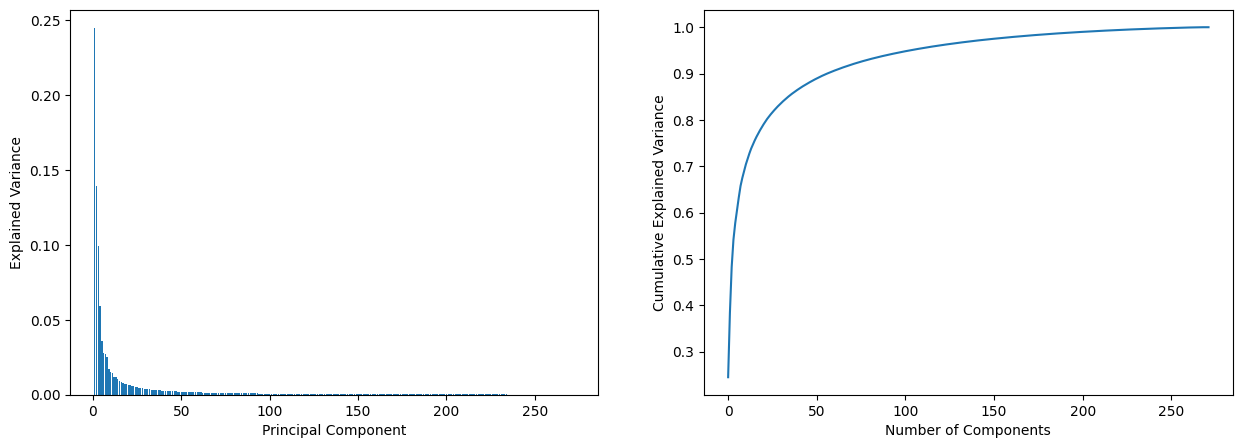

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot explained variance
ax[0].bar(range(1, n_tot_components+1), pca.explained_variance_ratio_)
ax[0].set_xlabel('Principal Component')
ax[0].set_ylabel('Explained Variance')

# Plot cumulative explained variance
ax[1].plot(np.cumsum(pca.explained_variance_ratio_))
ax[1].set_xlabel('Number of Components')
ax[1].set_ylabel('Cumulative Explained Variance')

In [17]:
# Select number of components to explain approx. 90% variance
n_components_95 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f'Number of components to explain ~95% variance: {n_components_95}')

actual_pca = PCA(n_components=n_components_95)
actual_scores = actual_pca.fit_transform(J_centered)
actual_components = actual_pca.components_

Number of components to explain ~95% variance: 104


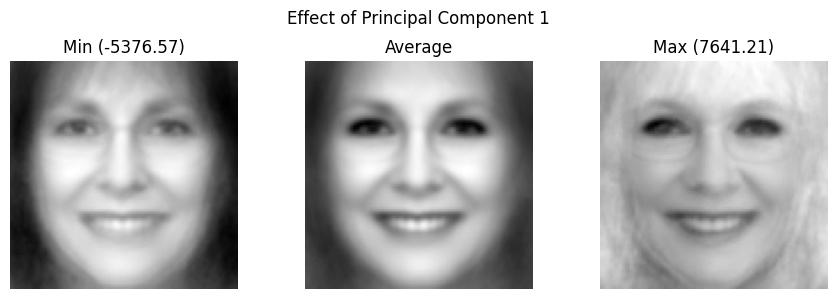

In [18]:
# For PC1, visualize variation
min_score = np.min(actual_scores[:, 0])
max_score = np.max(actual_scores[:, 0])

# Three images: min, mean, max
# Image components weighted by min/max scores added onto the average image shows the effect of that component
img_min = (mean_J + min_score * actual_components[0]).reshape(100, 100)
img_avg = mean_J.reshape(100, 100)
img_max = (mean_J + max_score * actual_components[0]).reshape(100, 100)

fig, axes = plt.subplots(1, 3, figsize=(9, 3))

titles = [f"Min ({min_score:.2f})", "Average", f"Max ({max_score:.2f})"]
imgs = [img_min, img_avg, img_max]

for ax, img, title in zip(axes, imgs, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.suptitle(f"Effect of Principal Component 1")
plt.tight_layout()
plt.show()

# Linear Regression (w/ Feature Selection)

In [19]:
lin_reg = LinearRegression()
selector = SequentialFeatureSelector(lin_reg)
selector = selector.fit(actual_scores, avg_ratings['Average_Rating'])

In [20]:
selected_features = selector.get_support()
selected_indices = np.where(selected_features)[0]
print(f"Number of selected PCs: {len(selected_indices)} out of {n_components_95}\nSelected PCs: {selected_indices}")

Number of selected PCs: 52 out of 104
Selected PCs: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 26 27
 28 30 32 35 36 38 39 42 43 44 50 52 56 57 58 61 62 64 65 66 67 76 82 95
 96 97 98 99]


In [21]:
# Fit model with selected features
lin_reg.fit(actual_scores[:, selected_indices], avg_ratings['Average_Rating'])
w = lin_reg.coef_
sigma = lin_reg.intercept_

# Generate Syntentic Images

In [22]:
# Calculate w^Tw
w_tw = np.dot(w, w)
print(f"w^Tw: {w_tw}")

w^Tw: 5.469867209535869e-06


In [23]:
# Generate scores
# One for each of the five rating labels
rating_labels = [1, 2, 3, 4, 5, 10.5]
generated_scores = []

for idx, rating in enumerate(rating_labels):
    gen_score = (rating_labels[idx]-sigma)*(w/w_tw)
    generated_scores.append(gen_score)

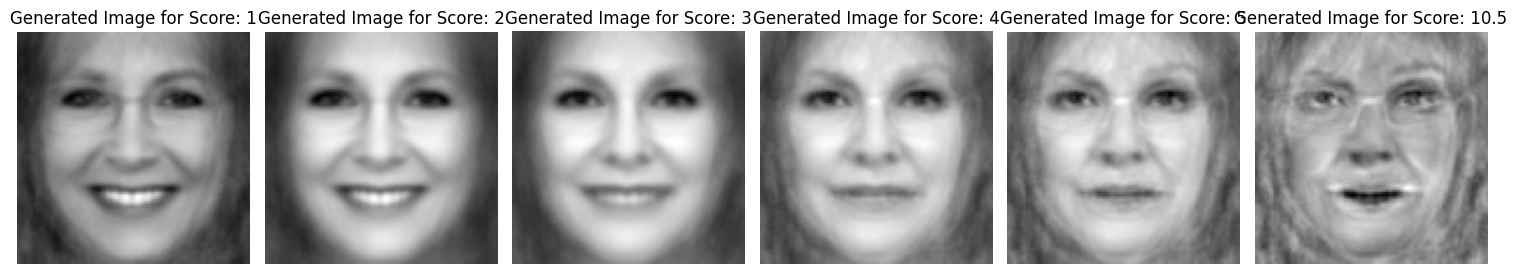

In [24]:
# Generate images
fig, ax = plt.subplots(1, len(rating_labels), figsize=(15, 3))

for i, val in enumerate(zip(rating_labels, generated_scores)):
    rating = val[0]
    score = val[1]

    gen_img = mean_J + np.dot(score, actual_components[selected_indices])
    gen_img_reshaped = gen_img.reshape(100, 100)
    
    ax[i].imshow(gen_img_reshaped, cmap='gray')
    ax[i].set_title(f"Generated Image for Score: {rating}")
    ax[i].axis('off')
    
plt.tight_layout()